This notebook is by Anastasia Ruzmaikina.

Here we analyse a dataset of nearly 5000 movies. The goal is to be able to predict if the movie is profitable given all the information available about the movie. The available data columns are the title, names of actors and actresses, movie genres, vote count, movie budget etc.

We use Naive Bayes Classifier to predict if a movie is profitable. Naive Bayes Classifier is not as suitable for this data set as other classifiers. It predicts if a movie is profitable with accuracy 73%.


In [299]:
# Data manipulation
import numpy as np 
import pandas as pd

# Data Visualazation
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
import time
import statsmodels.api as sm

import random
import scipy.optimize

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

We download the Movie Dataset from the Harvard Edx website.

In [300]:
df = pd.read_csv("https://courses.edx.org/asset-v1:HarvardX+PH526x+2T2019+type@asset+block@movie_data.csv", index_col=0)

df

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast
0,237000000,"Action, Adventure, Fantasy, Science Fiction",http://www.avatarmovie.com/,19995,"culture clash, future, space war, space colony...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"Ingenious Film Partners, Twentieth Century Fox...",...,2787965087,162.0,"English, Español",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"Sam Worthington, Zoe Saldana, Sigourney Weaver..."
1,300000000,"Adventure, Fantasy, Action",http://disney.go.com/disneypictures/pirates/,285,"ocean, drug abuse, exotic island, east india t...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",...,961000000,169.0,English,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"Johnny Depp, Orlando Bloom, Keira Knightley, S..."
2,245000000,"Action, Adventure, Crime",http://www.sonypictures.com/movies/spectre/,206647,"spy, based on novel, secret agent, sequel, mi6...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"Columbia Pictures, Danjaq, B24",...,880674609,148.0,"Français, English, Español, Italiano, Deutsch",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,"Daniel Craig, Christoph Waltz, Léa Seydoux, Ra..."
3,250000000,"Action, Crime, Drama, Thriller",http://www.thedarkknightrises.com/,49026,"dc comics, crime fighter, terrorist, secret id...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",...,1084939099,165.0,English,Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,"Christian Bale, Michael Caine, Gary Oldman, An..."
4,260000000,"Action, Adventure, Science Fiction",http://movies.disney.com/john-carter,49529,"based on novel, mars, medallion, space travel,...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,Walt Disney Pictures,...,284139100,132.0,English,Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,"Taylor Kitsch, Lynn Collins, Samantha Morton, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"Action, Crime, Thriller",NaN,9367,"united states–mexico barrier, legs, arms, pape...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,Columbia Pictures,...,2040920,81.0,Español,Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238,9367,"Carlos Gallardo, Jaime de Hoyos, Peter Marquar..."
4799,9000,"Comedy, Romance",NaN,72766,NaN,en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,NaN,...,0,85.0,NaN,Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5,72766,"Edward Burns, Kerry Bishé, Marsha Dietlein, Ca..."
4800,0,"Comedy, Drama, Romance, TV Movie",http://www.hallmarkchannel.com/signedsealeddel...,231617,"date, love at first sight, narration, investig...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"Front Street Pictures, Muse Entertainment Ente...",...,0,120.0,English,Released,NaN,"Signed, Sealed, Delivered",7.0,6,231617,"Eric Mabius, Kristin Booth, Crystal Lowe, Geof..."
4801,0,NaN,http://shanghaicalling.com/,126186,NaN,en,Shanghai Calling,When ambitious New York attorney Sam is sent t...,0.857008,NaN,...,0,98.0,English,Released,A New Yorker in Shanghai,Shanghai Calling,5.7,7,126186,"Daniel Henney, Eliza Coupe, Bill Paxton, Alan ..."


We can look at the shape of the data set:

In [301]:
df.shape

(4803, 22)

We replace infinite values with NaN values in the data frame. NaN values are handled later.

In [302]:
df = df.replace(to_replace = np.inf, value = np.nan)
df = df.replace(to_replace = -np.inf, value = np.nan)

Next we do a one hot encoding of the 'genres' column.

First we identify how many different genres are present in the 'genres' column.

We split the genres into different columns. Each column contains 1's or 0's, one if that particlar genre is present in that row.

In [303]:
genr = []
for i in range(len(df['genres'])):
    temp = df['genres'].iloc[i]
    if not (isinstance(temp, float)):
       temp = temp.split(',')
       genr += temp
       
genre = list(set(genr))
for i in range(len(genre)):
    genre[i] = genre[i].strip()
genre = list(set(genre))
for item in genre:
    df[item] = df['budget']
for item in genre:
    for i in range(len(df['genres'])):
        if not (isinstance(df['genres'].iloc[i], float)):
             if item in df['genres'].iloc[i]:
                   df[item].iloc[i] = 1
             else:
                   df[item].iloc[i] = 0

We create a new column indicating if a movie is profitable.

The 'profitable' column is the difference between 'revenue' and 'budget' column.



In [304]:
df['profitable'] = df['revenue']
for i in range(len(df['revenue'])):
    if df['revenue'].iloc[i] >= df['budget'].iloc[i]:
        df['profitable'].iloc[i] = 1
    else:
        df['profitable'].iloc[i] = 0

In [305]:
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,Family,Mystery,Drama,Documentary,Romance,Western,War,Science Fiction,Animation,profitable
0,237000000,"Action, Adventure, Fantasy, Science Fiction",http://www.avatarmovie.com/,19995,"culture clash, future, space war, space colony...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"Ingenious Film Partners, Twentieth Century Fox...",...,0,0,0,0,0,0,0,1,0,1
1,300000000,"Adventure, Fantasy, Action",http://disney.go.com/disneypictures/pirates/,285,"ocean, drug abuse, exotic island, east india t...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",...,0,0,0,0,0,0,0,0,0,1
2,245000000,"Action, Adventure, Crime",http://www.sonypictures.com/movies/spectre/,206647,"spy, based on novel, secret agent, sequel, mi6...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"Columbia Pictures, Danjaq, B24",...,0,0,0,0,0,0,0,0,0,1
3,250000000,"Action, Crime, Drama, Thriller",http://www.thedarkknightrises.com/,49026,"dc comics, crime fighter, terrorist, secret id...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",...,0,0,1,0,0,0,0,0,0,1
4,260000000,"Action, Adventure, Science Fiction",http://movies.disney.com/john-carter,49529,"based on novel, mars, medallion, space travel,...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,Walt Disney Pictures,...,0,0,0,0,0,0,0,1,0,1


Descriptive Statistics.

Before solving the problem, it's very important to have a good understanding of data.

First we get the descriptive statistics of the data.

Then we get the information about missing values in the data



In [306]:
# Info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 43 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4775 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4391 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4452 non-null   object 
 10  production_countries  4629 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4716 non-null   object 
 15  status               

In [307]:
# Summary statistic of the data
df.describe()  

,budget,id,popularity,revenue,runtime,vote_average,vote_count,movie_id,TV Movie,Horror,...,Family,Mystery,Drama,Documentary,Romance,Western,War,Science Fiction,Animation,profitable
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000,4803.000000,4.803000e+03,4.803000e+03,...,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989,57165.484281,7.703537e+02,7.704601e+02,...,7.704589e+02,7.704245e+02,7.708303e+02,7.703750e+02,7.705382e+02,7.703691e+02,7.703821e+02,7.704635e+02,7.704008e+02,0.723923
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891,88694.614033,3.441409e+04,3.441408e+04,...,3.441408e+04,3.441409e+04,3.441408e+04,3.441409e+04,3.441408e+04,3.441409e+04,3.441409e+04,3.441408e+04,3.441409e+04,0.447102
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000,9014.500000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000,14629.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000,58610.500000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000,459488.000000,2.000000e+06,2.000000e+06,...,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,1.000000


In [308]:
# Get count of missing values in every column
print(df.isna().sum())

budget                     0
genres                    28
homepage                3091
id                         0
keywords                 412
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies     351
production_countries     174
release_date               1
revenue                    0
runtime                    2
spoken_languages          87
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
movie_id                   0
cast                      43
TV Movie                   0
Horror                     0
Comedy                     0
Adventure                  0
History                    0
Fantasy                    0
Crime                      0
Thriller                   0
Music                      0
Action                     0
Foreign                    0
Family                     0
Mystery       

Conclusions:

The data contains some categorical columns, these columns need to be handled before building the model.

Some columns have missing values, these need to be handled before building the model. Since the columns with missing values are categorical, we are not going to have a problem with dropping them.

The y variable (profitable) doesn't have any missing values, which is good.

Now we list the numeric and categorical columns.



In [309]:
# Create list of numeric and categorical columns and check if they have extra spaces in the column names
num_col = df.select_dtypes(include=np.number).columns
print("Numerical columns: \n",num_col)

cat_col = df.select_dtypes(exclude=np.number).columns
print("Categorical columns: \n",cat_col)

Numerical columns: 
 Index(['budget', 'id', 'popularity', 'revenue', 'runtime', 'vote_average',
       'vote_count', 'movie_id', 'TV Movie', 'Horror', 'Comedy', 'Adventure',
       'History', 'Fantasy', 'Crime', 'Thriller', 'Music', 'Action', 'Foreign',
       'Family', 'Mystery', 'Drama', 'Documentary', 'Romance', 'Western',
       'War', 'Science Fiction', 'Animation', 'profitable'],
      dtype='object')
Categorical columns: 
 Index(['genres', 'homepage', 'keywords', 'original_language', 'original_title',
       'overview', 'production_companies', 'production_countries',
       'release_date', 'spoken_languages', 'status', 'tagline', 'title',
       'cast'],
      dtype='object')


We already did one hot encoding on the 'genres' column, so we can drop the 'genres' column.

The only categorical column that can influence the 'profitable' column is the 'cast' column. But if we do a one hot encoding, we find that we need a hundred or more columns. Therefore it is impractical to use 'cast' data and we are going to drop the 'cast' column.

All other categorical columns have very little influence on the revenue from the movie, so we can drop them.

In addition we are going to drop the 'revenue' column, because it is linearly dependent on the related 'profitable' column we are going to predict.

We are going to drop the columns 'id' and 'movie_id', because they carry no information.



In [310]:
df = df.drop(columns=['genres', 'homepage', 'keywords', 'original_language', 'original_title',
       'overview', 'production_companies', 'production_countries',
       'release_date', 'spoken_languages', 'status', 'tagline', 'title',
       'cast', 'revenue', 'id', 'movie_id'])
df = df.dropna()
print(df.shape)

(4801, 26)


As a result of dropping categorical columns and the revenue column, only two rows remained with NaN values, when they were droppped the data frame has 4801 rows left.

In [311]:
df.head()

,budget,popularity,runtime,vote_average,vote_count,TV Movie,Horror,Comedy,Adventure,History,...,Family,Mystery,Drama,Documentary,Romance,Western,War,Science Fiction,Animation,profitable
0,237000000,150.437577,162.0,7.2,11800,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
1,300000000,139.082615,169.0,6.9,4500,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,245000000,107.376788,148.0,6.3,4466,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,250000000,112.312950,165.0,7.6,9106,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,260000000,43.926995,132.0,6.1,2124,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1


Exploratory data analysis is an approach to analyze or investigate data sets to find out patterns and see if any of the variables can be useful in predicting the y variables. Visual methods are often used to summarise the data. Primarily EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing tasks.

We are going to:

Check the distribution of target variable

Check the correlation between different features

Check the relation between different features

We can plot a pie chart for the distribution of values in the 'profitable' column.



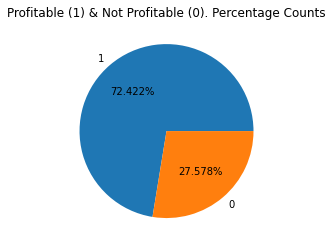

In [312]:
# get the set of distinct classes
labels = df.profitable.unique()

# get the count of each class
sizes = df.profitable.value_counts().values

# plot the class value counts
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('Profitable (1) & Not Profitable (0). Percentage Counts')
plt.show()

We plot the histograms of 'budget', 'popularity', 'runtime', 'vote_count', 'vote_average'.

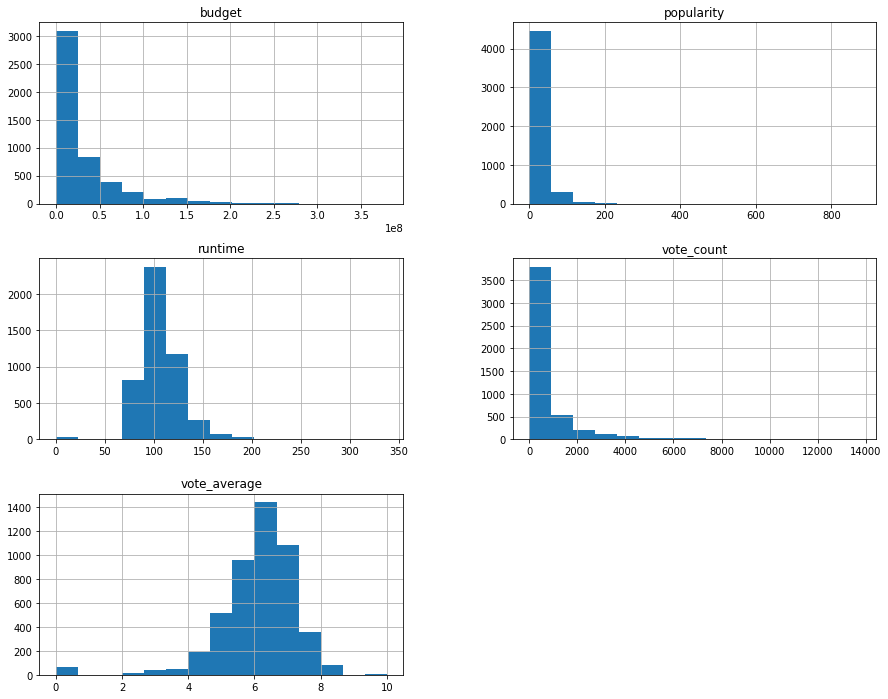

In [313]:
# plot histograms of the variables
params = df[['budget', 'popularity', 'runtime', 'vote_count', 'vote_average']]

params.hist(figsize=(15,12),bins = 15)

plt.show()

Data Preprocessing

In [314]:
# Split data in X and y dataset
X = df.drop(['profitable'], axis=1)
y = df['profitable']

In [315]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [316]:
# check the shape of X_train and X_test
X_train.shape, X_test.shape

((3360, 25), (1441, 25))

In [317]:
# check data types in X_train
X_train.dtypes

budget               int64
popularity         float64
runtime            float64
vote_average       float64
vote_count           int64
TV Movie             int64
Horror               int64
Comedy               int64
Adventure            int64
History              int64
Fantasy              int64
Crime                int64
Thriller             int64
Music                int64
Action               int64
Foreign              int64
Family               int64
Mystery              int64
Drama                int64
Documentary          int64
Romance              int64
Western              int64
War                  int64
Science Fiction      int64
Animation            int64
dtype: object

Engineering missing values in variables

In [318]:
# check missing values in numerical variables in X_train
X_train.isnull().sum()

budget             0
popularity         0
runtime            0
vote_average       0
vote_count         0
TV Movie           0
Horror             0
Comedy             0
Adventure          0
History            0
Fantasy            0
Crime              0
Thriller           0
Music              0
Action             0
Foreign            0
Family             0
Mystery            0
Drama              0
Documentary        0
Romance            0
Western            0
War                0
Science Fiction    0
Animation          0
dtype: int64

There are no missing values



We now have training and testing set ready for model building. Before that, we should map all the feature variables onto the same scale. It is called feature scaling.

In [319]:
X_train.head()

,budget,popularity,runtime,vote_average,vote_count,TV Movie,Horror,Comedy,Adventure,History,...,Foreign,Family,Mystery,Drama,Documentary,Romance,Western,War,Science Fiction,Animation
2354,30000000,53.670525,122.0,6.8,1573,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2630,15000000,30.983397,104.0,6.8,737,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
2117,20000000,11.624230,89.0,4.6,191,0,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0
4351,1000000,3.851000,100.0,6.2,33,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
1767,27000000,8.715822,99.0,5.5,98,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [320]:
# standardize features by removing the mean and scaling to unit variance
df.iloc[:, 0:25] = StandardScaler().fit_transform(df.iloc[:, 0:25])
data_matrix = df.values

# X: feature matrix (for this analysis, we exclude the 'high_value' variable from the dataset)
X = data_matrix[:, 0:25]

# y: labels vector
y = data_matrix[:, 25]

# data normalization
X = normalize(X, norm="l1")

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

df.head()

X.shape= (4801, 25) y.shape= (4801,)


,budget,popularity,runtime,vote_average,vote_count,TV Movie,Horror,Comedy,Adventure,History,...,Family,Mystery,Drama,Documentary,Romance,Western,War,Science Fiction,Animation,profitable
0,5.106231,4.052434,2.438088,0.929025,8.998200,-0.022392,-0.022395,-0.022402,-0.022368,-0.022393,...,-0.022395,-0.022394,-0.022406,-0.022392,-0.022397,-0.022392,-0.022393,-0.022366,-0.022393,1
1,6.653231,3.695551,2.747691,0.677213,3.085524,-0.022392,-0.022395,-0.022402,-0.022368,-0.022393,...,-0.022395,-0.022394,-0.022406,-0.022392,-0.022397,-0.022392,-0.022393,-0.022395,-0.022393,1
2,5.302675,2.699047,1.818881,0.173591,3.057985,-0.022392,-0.022395,-0.022402,-0.022368,-0.022393,...,-0.022395,-0.022394,-0.022406,-0.022392,-0.022397,-0.022392,-0.022393,-0.022395,-0.022393,1
3,5.425453,2.854189,2.570775,1.264773,6.816180,-0.022392,-0.022395,-0.022402,-0.022397,-0.022393,...,-0.022395,-0.022394,-0.022377,-0.022392,-0.022397,-0.022392,-0.022393,-0.022395,-0.022393,1
4,5.671009,0.704839,1.111217,0.005717,1.161069,-0.022392,-0.022395,-0.022402,-0.022368,-0.022393,...,-0.022395,-0.022394,-0.022406,-0.022392,-0.022397,-0.022392,-0.022393,-0.022366,-0.022393,1


Building Model 



Gaussian Naive Bayes Model



In [321]:
# Import GaussianNB
from sklearn.naive_bayes import GaussianNB

# instantiate the model
gnb = GaussianNB()

# fit the model
gnb.fit(X_train, y_train)

GaussianNB()

Predicting values

In [322]:
# Predicting the test and trained values
y_pred = gnb.predict(X_test)

In [325]:
y_pred[0:300]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

It is obvious that Naive Bayes Classifier predicts every movie as profitable. This means that Naive Bayes is not a good classifier to use for this data set.

Model Performance

In [326]:
from   sklearn.metrics import accuracy_score, confusion_matrix , classification_report

# Evaluate the model
def compute_evaluation_metric(y_actual, y_predicted):
    print("\n Accuracy Score : ",accuracy_score(y_actual,y_predicted))
    print("\n Confusion Matrix : \n",confusion_matrix(y_actual, y_predicted))
    print("\n Classification Report : \n",classification_report(y_actual, y_predicted))

In [327]:
compute_evaluation_metric(y_test, y_pred)


 Accuracy Score :  0.7307425399028452

 Confusion Matrix : 
 [[   0  388]
 [   0 1053]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       388
           1       0.73      1.00      0.84      1053

    accuracy                           0.73      1441
   macro avg       0.37      0.50      0.42      1441
weighted avg       0.53      0.73      0.62      1441



Bernoulli Naive Bayes Model


In [328]:
# Import BernoulliNB 
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()

# Fit into the model
bnb.fit(X_train, y_train)

BernoulliNB()

In [329]:
# Predicting the test and trained values
y_pred = bnb.predict(X_test)

In [330]:
# Model Evaluation
compute_evaluation_metric(y_test, y_pred)


 Accuracy Score :  0.7272727272727273

 Confusion Matrix : 
 [[   4  384]
 [   9 1044]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.31      0.01      0.02       388
           1       0.73      0.99      0.84      1053

    accuracy                           0.73      1441
   macro avg       0.52      0.50      0.43      1441
weighted avg       0.62      0.73      0.62      1441



Conclusion: The Naive Bayes Model is not a very good predictor of the profitability of a movie. The best accuracy it achieves is 73%

The reason the Naive Bayes Classifier is not accurate for this data set is that the assumption that the features are independent is not correct.